In [11]:
import os
import sys
import pandas as pd, geopandas as gp, matplotlib.pyplot as plt, numpy as np
import json
import fiona
import sys
import getpass
import requests
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from arcgis.gis import GIS
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.features import FeatureLayerCollection
import contextily as ctx

user = getpass.getuser()
sys.dont_write_bytecode = True

sys.path.insert(0, '/Users/{}/Box/DataViz Projects/Utility Code'.format(user))

from utils_io import *

In [2]:
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [3]:
pass_txt = '../../../passwords/arcgis_enterprise_pass.txt'
password = get_file_contents(pass_txt)

agol_pass_txt = '../../../passwords/agol_pass.txt'
agol_password = get_file_contents(agol_pass_txt)

In [4]:
#Connect to enterprise portal
gis = GIS("https://arcgis.ad.mtc.ca.gov/portal/", "jcroff", password)

In [5]:
#Connect to arcgis online
agol_gis = GIS('https://mtc.maps.arcgis.com/home/','content_MTC',agol_password)

# RHNA Site Selection Pre-Screening Dataset Processing

## Approach

Develop a parcel-level dataset containing factors required by HCD as well as optional factors such as whether the site is located within a high opportunity area, or a transportation priority area, any floor area ratio requirements of the site, etc. The dataset will be developed from a combination of publically available datasets as well as datasets developed by MTC/ABAG from local governments and counties throughout the Bay Area.

## Data Sources

**[Data Sources Inventory](https://mtcdrive.app.box.com/file/700718735166)**

## Pre-Processing Step
- This notebook is intented to support the overlay processing work to create the full housing element site selection dataset. Most of this work will not take place in one session so this pre-processing step is meant to be run before proceeding with steps below.  

In [14]:
#Box working directory path
data_dir = '../../../../../Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data/'

In [18]:
#Socrata housing site selection db 4x4
housing_site_db_id = '37cj-99yh'

In [19]:
#Pull housing site selection parcels from Socrata
parcels_geojson = pull_geojson_from_socrata(housing_site_db_id)

pulling 2142255 rows as geojson


In [21]:
# Convert to geojson to geodataframe
parcel_columns = ['joinid',
                  'geom_id',
                  'fipco',
                  'jurisdict',
                  'apn_frm',
                  'acres',
                  'tract_geoi',
                  'blkgp_geoi',
                  'x_centroid',
                  'y_centroid',
                  'geometry']

parcels = gp.GeoDataFrame.from_features(parcels_geojson['features'],
                                        columns=parcel_columns,
                                        crs={'init': 'epsg:4326'})

#Convert centroid columns to float data type
parcels['x_centroid'] = parcels['x_centroid'].astype(float)
parcels['y_centroid'] = parcels['y_centroid'].astype(float)

/Users/jcroff/anaconda3/envs/geo_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [22]:
#Create parcel centroid geodataframe
parcels_centroid = gp.GeoDataFrame(parcels,
                                  geometry=gp.points_from_xy(parcels.x_centroid,parcels.y_centroid),
                                   crs={'init': 'epsg:4326'})

parcels_centroid.head(5)

,joinid,geom_id,fipco,jurisdict,apn_frm,acres,tract_geoi,blkgp_geoi,x_centroid,y_centroid,geometry
0,SN173872,SL1942158,CA097,Santa Rosa,173-170-001,1.35036110020719,06097152400,060971524004,-122.704221,38.480388,POINT (-122.70422 38.48039)
1,AL044727,AL171604,CA001,Union City,483-42-103,5.27261949677121,06001440334,060014403341,-122.067495,37.595772,POINT (-122.06749 37.59577)
2,CC121569,CC630071,CA013,Walnut Creek,None,0.700718319622156,06013340001,060133400013,-122.071217,37.926688,POINT (-122.07122 37.92669)
3,AL066250,AL030349,CA001,Pleasanton,950-11-51,10.5813135682409,06001450701,060014507014,-121.811498,37.650312,POINT (-121.81150 37.65031)
4,SN116826,SL2006047,CA097,Unincorporated Sonoma,110-090-027,93.5877827281533,06097154000,060971540002,-122.856075,38.568910,POINT (-122.85607 38.56891)


## Step 4: Process opportunity datasets

#### TCAC/HCD Resource Opportunity Areas 2020

- TCAC/HCD Resource Opportunity Area data was last updated in early 2020. 
- TCAC/HCD Resource Opportunity Area dataset contains data for the entire Bay Area by census tract and block group. 
- Columns from this dataset that will be associated with parcels include:
    - Final Category
    
- To associate these data with parcels, we will use a two-step join operation. 
    - 1st join: join tract-level data to parcels using the tract geoid added to the framework dataset in earlier steps. This will be an 'inner' join as we only care about the matching records. 
    - 2nd join: join block group-level data to parcels using the block geoid added to the framework dataset in earlier steps. This will be an 'inner' join as we again only care about matching records. 
    - Blocks and Tracts were added to the framework dataset using a point in polygon method. 
    - Urban Areas provide data at the tract level while rural area data were provided at the block group level.

#### HUD Fair Market Rents

- Fair Market Rents (FMRs) data was last updated in 2019.
- Fair Market Rents (FMRs) are used to determine payment standard amounts for the Housing Choice Voucher program, to determine initial renewal rents for some expiring project-based Section 8 contracts, to determine initial rents for housing assistance payment (HAP) contracts in the Moderate Rehabilitation Single Room Occupancy program (Mod Rehab), rent ceilings for rental units in both the HOME Investment Partnerships program and the Emergency Solution Grants program, calculation of maximum award amounts for Continuum of Care recipients and the maximum amount of rent a recipient may pay for property leased with Continuum of Care funds, and calculation of flat rents in Public Housing units. 
- The U.S. Department of Housing and Urban Development (HUD) annually estimates FMRs for Office of Management and Budget (OMB) defined metropolitan areas, some HUD defined subdivisions of OMB metropolitan areas and each nonmetropolitan county. 42 USC 1437f requires FMRs be posted at least 30 days before they are effective and that they are effective at the start of the federal fiscal year (generally October 1).

- Columns from this dataset that will be associated with parcels include: 
    - 0 Bedroom Fair Market Rent
    - 1 Bedroom Fair Market Rent
    - 2 Bedroom Fair Market Rent
    - 3 Bedroom Fair Market Rent
    - 4 Bedroom Fair Market Rent
    - 4 Plus Bedroom Fair Market Rent

### Process TCAC/HCD Resource Opportunity Areas 2020

In [4]:
data_dir

'../../../Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data/'

In [5]:
ls '../../../Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data/tabular'

ctcac_hcd_final_2020_public.xlsx


In [40]:
#Read in 2020 TCAC/HCD Resource Opportunity Areas

resource_areas = pd.read_excel(os.path.join(data_dir,'tabular/ctcac_hcd_final_2020_public.xlsx'),
                              dtype={'Census Tract':str,
                                     'Census Block Group':str})

In [41]:
#Inspect resource areas
resource_areas.head(5)

,Census Tract,Census Block Group,County,County ID,Region,Economic Domain Score (by region),Environmental Domain Score (by region),Education Domain Score (by region),Composite Index Score,Final Category
0,06001400100,NaN,Alameda,6001.0,Bay Area Region,0.826,0.406,0.736,0.433,High Resource
1,06001400200,NaN,Alameda,6001.0,Bay Area Region,0.935,0.754,0.794,0.683,Highest Resource
2,06001400300,NaN,Alameda,6001.0,Bay Area Region,0.911,0.741,0.340,0.235,High Resource
3,06001400400,NaN,Alameda,6001.0,Bay Area Region,0.877,0.747,0.429,0.289,High Resource
4,06001400500,NaN,Alameda,6001.0,Bay Area Region,0.802,0.865,0.586,0.397,High Resource


In [42]:
#Return info about resource areas
resource_areas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10144 entries, 0 to 10143
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Census Tract                            10144 non-null  object 
 1   Census Block Group                      3093 non-null   object 
 2   County                                  10144 non-null  object 
 3   County ID                               10143 non-null  float64
 4   Region                                  10144 non-null  object 
 5   Economic Domain Score (by region)       9635 non-null   float64
 6   Environmental Domain Score (by region)  9635 non-null   float64
 7   Education Domain Score (by region)      9635 non-null   float64
 8   Composite Index Score                   8786 non-null   float64
 9   Final Category                          9635 non-null   object 
dtypes: float64(5), object(5)
memory usage: 792.6+ KB


In [43]:
resource_areas[resource_areas['Region'] == 'Bay Area Region'].shape

(1513, 10)

In [44]:
resource_areas['Final Category'].unique()

array(['High Resource', 'Highest Resource',
       'Moderate Resource (Rapidly Changing)', 'Moderate Resource',
       'Low Resource', 'High Segregation & Poverty', nan], dtype=object)

In [45]:
resource_areas['Region'].unique()

array(['Bay Area Region', 'Capital Region', 'Central Valley Region',
       'Inland Empire Region', 'Los Angeles Region',
       'Central Coast Region', 'Orange County Region', 'San Diego Region',
       'Rural Areas'], dtype=object)

In [46]:
#rename columns
resource_areas.rename(columns={'Census Tract':'tract_geoi',
                               'Census Block Group':'blkgp_geoi',
                               'Final Category':'reso_level'},inplace=True)

In [47]:
#subset resource areas at the tract level geography
ra_tracts = resource_areas[(resource_areas['tract_geoi'].notnull()) & 
                           (resource_areas['Region'] == 'Bay Area Region')]

In [48]:
ra_tracts.head(5)

,tract_geoi,blkgp_geoi,County,County ID,Region,Economic Domain Score (by region),Environmental Domain Score (by region),Education Domain Score (by region),Composite Index Score,reso_level
0,06001400100,NaN,Alameda,6001.0,Bay Area Region,0.826,0.406,0.736,0.433,High Resource
1,06001400200,NaN,Alameda,6001.0,Bay Area Region,0.935,0.754,0.794,0.683,Highest Resource
2,06001400300,NaN,Alameda,6001.0,Bay Area Region,0.911,0.741,0.340,0.235,High Resource
3,06001400400,NaN,Alameda,6001.0,Bay Area Region,0.877,0.747,0.429,0.289,High Resource
4,06001400500,NaN,Alameda,6001.0,Bay Area Region,0.802,0.865,0.586,0.397,High Resource


In [49]:
ra_parcel_tracts = pd.merge(parcels[['joinid','tract_geoi']],
                            ra_tracts[['tract_geoi','reso_level']], 
                            on='tract_geoi',
                            how='inner')

In [50]:
ra_parcel_tracts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1982228 entries, 0 to 1982227
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   joinid      object
 1   tract_geoi  object
 2   reso_level  object
dtypes: object(3)
memory usage: 60.5+ MB


In [51]:
parcels.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2142255 entries, 0 to 2142254
Data columns (total 9 columns):
 #   Column      Dtype   
---  ------      -----   
 0   joinid      object  
 1   fipco       object  
 2   jurisdict   object  
 3   apn_frm     object  
 4   acres       object  
 5   tract_geoi  object  
 6   blkgp_geoi  object  
 7   reso_level  object  
 8   geometry    geometry
dtypes: geometry(1), object(8)
memory usage: 147.1+ MB


In [52]:
ra_parcel_tracts.head(10)

,joinid,tract_geoi,reso_level
0,SC257788,06085503218,Low Resource
1,SC257815,06085503218,Low Resource
2,SC257919,06085503218,Low Resource
3,SC257960,06085503218,Low Resource
4,SC258065,06085503218,Low Resource
5,SC260847,06085503218,Low Resource
6,SC260970,06085503218,Low Resource
7,SC262229,06085503218,Low Resource
8,SC262448,06085503218,Low Resource
9,SC263710,06085503218,Low Resource


In [53]:
#subset rural area block groups
ra_blkgp = resource_areas[(resource_areas['blkgp_geoi'].notnull()) & 
                           (resource_areas['Region'] == 'Rural Areas')]

In [54]:
ra_blkgp.head(5)

,tract_geoi,blkgp_geoi,County,County ID,Region,Economic Domain Score (by region),Environmental Domain Score (by region),Education Domain Score (by region),Composite Index Score,reso_level
7051,06003010000,060030100001,Alpine,6003.0,Rural Areas,NaN,NaN,NaN,NaN,NaN
7052,06003010000,060030100002,Alpine,6003.0,Rural Areas,NaN,NaN,NaN,NaN,NaN
7053,06005000101,060050001011,Amador,6005.0,Rural Areas,0.192,0.885,0.115,-0.163,Moderate Resource
7054,06005000101,060050001012,Amador,6005.0,Rural Areas,0.115,0.885,0.115,-0.170,Low Resource
7055,06005000101,060050001013,Amador,6005.0,Rural Areas,0.077,0.885,0.115,-0.271,Low Resource


In [57]:
#Join to parcels
ra_parcel_blkgp = pd.merge(parcels[['joinid','blkgp_geoi']],
                          ra_blkgp[['blkgp_geoi','reso_level']],
                          on='blkgp_geoi',
                          how='inner')

In [58]:
ra_parcel_blkgp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158290 entries, 0 to 158289
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   joinid      158290 non-null  object
 1   blkgp_geoi  158290 non-null  object
 2   reso_level  156251 non-null  object
dtypes: object(3)
memory usage: 4.8+ MB


In [60]:
ra_parcel_blkgp.head(5)

,joinid,blkgp_geoi,reso_level
0,SC257886,060855135001,Low Resource
1,SC258294,060855135001,Low Resource
2,SC259092,060855135001,Low Resource
3,SC259228,060855135001,Low Resource
4,SC259712,060855135001,Low Resource


In [61]:
ra_parcels_tracts_blkgp = ra_parcel_tracts.append(ra_parcel_blkgp)

In [63]:
ra_parcels_tracts_blkgp.head(10)

,joinid,tract_geoi,reso_level,blkgp_geoi
0,SC257788,06085503218,Low Resource,NaN
1,SC257815,06085503218,Low Resource,NaN
2,SC257919,06085503218,Low Resource,NaN
3,SC257960,06085503218,Low Resource,NaN
4,SC258065,06085503218,Low Resource,NaN
5,SC260847,06085503218,Low Resource,NaN
6,SC260970,06085503218,Low Resource,NaN
7,SC262229,06085503218,Low Resource,NaN
8,SC262448,06085503218,Low Resource,NaN
9,SC263710,06085503218,Low Resource,NaN


In [64]:
ra_parcels_tracts_blkgp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140518 entries, 0 to 158289
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   joinid      object
 1   tract_geoi  object
 2   reso_level  object
 3   blkgp_geoi  object
dtypes: object(4)
memory usage: 81.7+ MB


In [65]:
ra_parcels_tracts_blkgp[ra_parcels_tracts_blkgp['blkgp_geoi'].notnull()]

,joinid,tract_geoi,reso_level,blkgp_geoi
0,SC257886,NaN,Low Resource,060855135001
1,SC258294,NaN,Low Resource,060855135001
2,SC259092,NaN,Low Resource,060855135001
3,SC259228,NaN,Low Resource,060855135001
4,SC259712,NaN,Low Resource,060855135001
...,...,...,...,...
158285,SN173115,NaN,Moderate Resource,060971538093
158286,SN173116,NaN,Moderate Resource,060971538093
158287,SN173117,NaN,Moderate Resource,060971538093
158288,SN173180,NaN,Moderate Resource,060971538093


In [66]:
#Upsert to socrata
upsert_df_socrata(ra_parcels_tracts_blkgp[['joinid','reso_level']],housing_site_db_id,chunksize=100000)

upserting data to Socrata in 22 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
data upserted to ce94-ebgq
took 9.0543 minutes


In [ ]:
# #Test process on subset of parcels
# resource_areas_nad83_sf = resource_areas_nad83[resource_areas_nad83['county'] == 'San Francisco']

# resource_areas_nad83_sf.head(5)

# parcels_resource_area_overlay_sf = gp.overlay(parcels_nad83_gdf,
#                                               resource_areas_nad83_sf[['finalcat','geometry']],
#                                               how='intersection')

# #Calculate overlay area
# parcels_resource_area_overlay_sf['overlay_area'] = parcels_resource_area_overlay_sf['geometry'].area

# #Calculate percentate overlay
# parcels_resource_area_overlay_sf['pct_overlay'] = (parcels_resource_area_overlay_sf['overlay_area'] /
#                                                   parcels_resource_area_overlay_sf['parcel_area'])
# #Get info 
# #(149828 rows)
# parcels_resource_area_overlay_sf.info()

# parcels_resource_area_overlay_sf[parcels_resource_area_overlay_sf['pct_overlay'] < 1]

# #Select parcels with the largest area within resource areas
# parcels_resource_area_overlay_largest_sf = (parcels_resource_area_overlay_sf
#                                             .iloc[parcels_resource_area_overlay_sf
#                                                   .groupby(['county_apn_id'])['pct_overlay']
#                                                   .idxmax()])

# #Check for duplicates
# #(0,11)
# parcels_resource_area_overlay_largest_sf[parcels_resource_area_overlay_largest_sf.duplicated(subset=['county_apn_id'])].shape

# #Get info again
# #(149657 rows)
# #Loss of rows 
# parcels_resource_area_overlay_largest_sf.info()

### Process HUD Fair Market Rents dataset

In [71]:
data_dir

'../../../Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data/'

In [72]:
!ls '../../../Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data/'

Intermediate Data
Potential_data_sources.xlsx
site_selection_prescreening_database.gdb
tabular


In [73]:
fiona.listlayers(os.path.join(data_dir,'site_selection_prescreening_database.gdb'))

['COCs_ACS2014_2018',
 'priority_development_areas_current',
 'US_Treasury_Opportunity_Zones_Bay_Area',
 'oehha_calenviroscreen3_bay_area',
 'u_richmond_mapping_inequality_redlining_07_2020',
 'hud_fair_market_rents_bay_area_7_28_20',
 'ca_healthy_places_index_bay_area_04_04_2018',
 'ctcac_hcd_resource_opportunity_areas_2020']

In [74]:
fmr = gp.read_file(os.path.join(data_dir,'site_selection_prescreening_database.gdb'),
                   driver='FileGDB',
                   layer='hud_fair_market_rents_bay_area_7_28_20')

In [75]:
fmr.head(10)

,FMR_0BDR,FMR_1BDR,FMR_2BDR,FMR_3BDR,FMR_4BDR,FMR_AREANAME,FMR_CODE,FMR_4PLUSBDR,Shape__Area,Shape__Length,Shape_Length,Shape_Area,geometry
0,1095.0,1289.0,1705.0,2465.0,2685.0,"Napa, CA MSA",METRO34900M34900,2685.0,3.340480e+09,349734.279550,2.788192,0.210944,"MULTIPOLYGON (((-122.35430 38.83715, -122.3499..."
1,983.0,1184.0,1443.0,2086.0,2531.0,"Vallejo-Fairfield, CA MSA",METRO46700M46700,2531.0,3.744063e+09,337353.781359,2.756668,0.237205,"MULTIPOLYGON (((-121.88139 38.53820, -121.8798..."
2,1397.0,1693.0,2109.0,2902.0,3558.0,"Oakland-Fremont, CA HUD Metro FMR Area",METRO41860MM5775,3558.0,6.241888e+09,621020.566568,5.063336,0.398083,"MULTIPOLYGON (((-121.58225 38.09489, -121.5812..."
3,1822.0,2255.0,2809.0,3663.0,3912.0,"San Francisco, CA HUD Metro FMR Area",METRO41860MM7360,3912.0,4.275324e+09,955407.207799,7.646650,0.272706,"MULTIPOLYGON (((-122.90949 38.31439, -122.9081..."
4,1865.0,2212.0,2712.0,3658.0,4198.0,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",METRO41940M41940,4198.0,5.314492e+09,470583.392021,3.858972,0.341458,"MULTIPOLYGON (((-121.86339 37.48462, -121.8007..."
5,1254.0,1447.0,1887.0,2728.0,3298.0,"Santa Rosa, CA MSA",METRO42220M42220,3298.0,6.739300e+09,497301.082655,4.051204,0.425442,"MULTIPOLYGON (((-123.01878 38.85237, -123.0069..."


In [76]:
fmr.columns = map(str.lower, fmr.columns)

In [77]:
fmr.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   fmr_0bdr       6 non-null      float64 
 1   fmr_1bdr       6 non-null      float64 
 2   fmr_2bdr       6 non-null      float64 
 3   fmr_3bdr       6 non-null      float64 
 4   fmr_4bdr       6 non-null      float64 
 5   fmr_areaname   6 non-null      object  
 6   fmr_code       6 non-null      object  
 7   fmr_4plusbdr   6 non-null      float64 
 8   shape__area    6 non-null      float64 
 9   shape__length  6 non-null      float64 
 10  shape_length   6 non-null      float64 
 11  shape_area     6 non-null      float64 
 12  geometry       6 non-null      geometry
dtypes: float64(10), geometry(1), object(2)
memory usage: 752.0+ bytes


In [78]:
fmr.rename(columns={'fmr_4plusbdr':'fmr_4plbdr'},inplace=True)

In [79]:
fmr.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   fmr_0bdr       6 non-null      float64 
 1   fmr_1bdr       6 non-null      float64 
 2   fmr_2bdr       6 non-null      float64 
 3   fmr_3bdr       6 non-null      float64 
 4   fmr_4bdr       6 non-null      float64 
 5   fmr_areaname   6 non-null      object  
 6   fmr_code       6 non-null      object  
 7   fmr_4plbdr     6 non-null      float64 
 8   shape__area    6 non-null      float64 
 9   shape__length  6 non-null      float64 
 10  shape_length   6 non-null      float64 
 11  shape_area     6 non-null      float64 
 12  geometry       6 non-null      geometry
dtypes: float64(10), geometry(1), object(2)
memory usage: 752.0+ bytes


In [82]:
fmr.crs

{'init': 'epsg:4326'}

In [98]:
fmr_parcels_centroid = gp.sjoin(parcels_centroid,
                               fmr,
                               how='left',
                               op='intersects')

In [99]:
fmr_parcels_centroid.head(5)

,joinid,fipco,jurisdict,apn_frm,acres,tract_geoi,blkgp_geoi,reso_level,x_centroid,y_centroid,...,fmr_2bdr,fmr_3bdr,fmr_4bdr,fmr_areaname,fmr_code,fmr_4plbdr,shape__area,shape__length,shape_length,shape_area
0,SC257788,CA085,San Jose,None,0.118218005006097,06085503218,060855032182,None,-121.825062,37.278626,...,2712.0,3658.0,4198.0,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",METRO41940M41940,4198.0,5.314492e+09,470583.392021,3.858972,0.341458
1,SC257789,CA085,San Jose,None,0.148489035363832,06085512005,060855120051,None,-121.873356,37.264377,...,2712.0,3658.0,4198.0,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",METRO41940M41940,4198.0,5.314492e+09,470583.392021,3.858972,0.341458
2,SC257790,CA085,San Jose,None,0.125657625517105,06085502702,060855027024,None,-121.940662,37.255301,...,2712.0,3658.0,4198.0,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",METRO41940M41940,4198.0,5.314492e+09,470583.392021,3.858972,0.341458
3,SC257791,CA085,Los Gatos,None,0.294159103918568,06085507205,060855072054,None,-121.989760,37.253136,...,2712.0,3658.0,4198.0,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",METRO41940M41940,4198.0,5.314492e+09,470583.392021,3.858972,0.341458
4,SC257792,CA085,San Jose,None,1.06964856345635,06085500100,060855001001,None,-121.894749,37.362045,...,2712.0,3658.0,4198.0,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",METRO41940M41940,4198.0,5.314492e+09,470583.392021,3.858972,0.341458


In [100]:
fmr_parcels_centroid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2142255 entries, 0 to 2142254
Data columns (total 24 columns):
 #   Column         Dtype   
---  ------         -----   
 0   joinid         object  
 1   fipco          object  
 2   jurisdict      object  
 3   apn_frm        object  
 4   acres          object  
 5   tract_geoi     object  
 6   blkgp_geoi     object  
 7   reso_level     object  
 8   x_centroid     float64 
 9   y_centroid     float64 
 10  geometry       geometry
 11  index_right    float64 
 12  fmr_0bdr       float64 
 13  fmr_1bdr       float64 
 14  fmr_2bdr       float64 
 15  fmr_3bdr       float64 
 16  fmr_4bdr       float64 
 17  fmr_areaname   object  
 18  fmr_code       object  
 19  fmr_4plbdr     float64 
 20  shape__area    float64 
 21  shape__length  float64 
 22  shape_length   float64 
 23  shape_area     float64 
dtypes: float64(13), geometry(1), object(10)
memory usage: 408.6+ MB


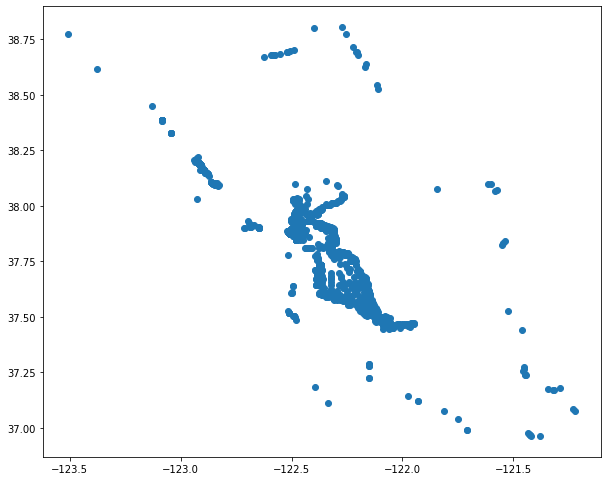

In [104]:
fmr_parcels_centroid[fmr_parcels_centroid['fmr_code'].isnull()].plot(figsize=(10,10));

In [105]:
#Subset not null values 
fmr_parcels_centroid_sub = fmr_parcels_centroid[fmr_parcels_centroid['fmr_code'].notnull()]

In [106]:
fmr_parcels_centroid_sub.shape

(2139678, 24)

In [107]:
fmr_parcels_centroid_sub.columns

Index(['joinid', 'fipco', 'jurisdict', 'apn_frm', 'acres', 'tract_geoi',
       'blkgp_geoi', 'reso_level', 'x_centroid', 'y_centroid', 'geometry',
       'index_right', 'fmr_0bdr', 'fmr_1bdr', 'fmr_2bdr', 'fmr_3bdr',
       'fmr_4bdr', 'fmr_areaname', 'fmr_code', 'fmr_4plbdr', 'shape__area',
       'shape__length', 'shape_length', 'shape_area'],
      dtype='object')

In [108]:
#upsert to socrata
sub_columns = ['joinid','fmr_0bdr', 'fmr_1bdr', 'fmr_2bdr', 'fmr_3bdr','fmr_4bdr','fmr_4plbdr']
upsert_df_socrata(fmr_parcels_centroid_sub[sub_columns],housing_site_db_id,chunksize=50000)

upserting data to Socrata in 43 chunks of 50000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
upserted chunk 22
upserted chunk 23
upserted chunk 24
upserted chunk 25
upserted chunk 26
upserted chunk 27
upserted chunk 28
upserted chunk 29
upserted chunk 30
upserted chunk 31
upserted chunk 32
upserted chunk 33
upserted chunk 34
upserted chunk 35
upserted chunk 36
upserted chunk 37
upserted chunk 38
upserted chunk 39
upserted chunk 40
upserted chunk 41
upserted chunk 42
data upserted to ce94-ebgq
took 11.1532 minutes


## Step 5: Process accessibility datasets

#### MTC/ABAG Transit Rich Areas 2020 (TRAs)

- Transit rich areas will be assigned to parcels using a point (representative centroid) in polygon (Transit Rich Area) method. This is a simple boolean flagging (0: Outside TRA, 1: Inside TRA) 

A Transit-Rich Area is defined as areas 1/2 mile of:
- An existing, under construction, or fully funded rail station or ferry terminal
- A rail station or ferry terminal included in the PBA 2050 Final Blueprint
- A bus stop with headways of 15 minutes or less during the AM (6:00 - 10:00 AM) and PM (3:00 - 7:00 PM) peak periods in January 2020

### Process Transit Rich Areas overlay

In [36]:
tra_2020 = pull_geodata_from_argis('81a628f55b3d458095c9770331aca5a4',client=gis) 
#tra_2020

CRSError: Invalid CRS input: {'EPSG:4326'}

In [51]:
fiona.listlayers(os.path.join(data_dir,'site_selection_prescreening_database.gdb'))

['COCs_ACS2014_2018',
 'priority_development_areas_current',
 'US_Treasury_Opportunity_Zones_Bay_Area',
 'oehha_calenviroscreen3_bay_area',
 'u_richmond_mapping_inequality_redlining_07_2020',
 'hud_fair_market_rents_bay_area_7_28_20',
 'ca_healthy_places_index_bay_area_04_04_2018',
 'ctcac_hcd_resource_opportunity_areas_2020',
 'transit_rich_areas_2020',
 'cdf_fire_responsibility_areas_and_risk']

In [37]:
#Read fire severity risk data from project fgdb
tra = gp.read_file(os.path.join(data_dir,'site_selection_prescreening_database.gdb'),
                  driver='FileGDB',
                  layer='transit_rich_areas_2020')

In [39]:
tra.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [40]:
#rename dissolve column to tra
tra.rename(columns={'diss':'tra'},inplace=True)

In [41]:
#Check CRS
print(parcels_centroid.crs)
print(tra.crs)

+init=epsg:4326 +type=crs
epsg:4326


In [42]:
#Spatially join parcel centroids and tras
tra_parcel_centroid = gp.sjoin(parcels_centroid,
                              tra,
                              how='left',
                              op='intersects')

/Users/jcroff/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  """


In [44]:
tra_parcel_centroid.head(5)

,joinid,geom_id,fipco,jurisdict,apn_frm,acres,tract_geoi,blkgp_geoi,x_centroid,y_centroid,geometry,index_right,tra,f_name,Shape_Length,Shape_Area
0,SN173872,SL1942158,CA097,Santa Rosa,173-170-001,1.35036110020719,06097152400,060971524004,-122.704221,38.480388,POINT (-122.70422 38.48039),NaN,NaN,NaN,NaN,NaN
1,AL044727,AL171604,CA001,Union City,483-42-103,5.27261949677121,06001440334,060014403341,-122.067495,37.595772,POINT (-122.06749 37.59577),0.0,1.0,Transit Rich Areas,12.296486,0.122582
2,CC121569,CC630071,CA013,Walnut Creek,None,0.700718319622156,06013340001,060133400013,-122.071217,37.926688,POINT (-122.07122 37.92669),NaN,NaN,NaN,NaN,NaN
3,AL066250,AL030349,CA001,Pleasanton,950-11-51,10.5813135682409,06001450701,060014507014,-121.811498,37.650312,POINT (-121.81150 37.65031),0.0,1.0,Transit Rich Areas,12.296486,0.122582
4,SN116826,SL2006047,CA097,Unincorporated Sonoma,110-090-027,93.5877827281533,06097154000,060971540002,-122.856075,38.568910,POINT (-122.85607 38.56891),NaN,NaN,NaN,NaN,NaN


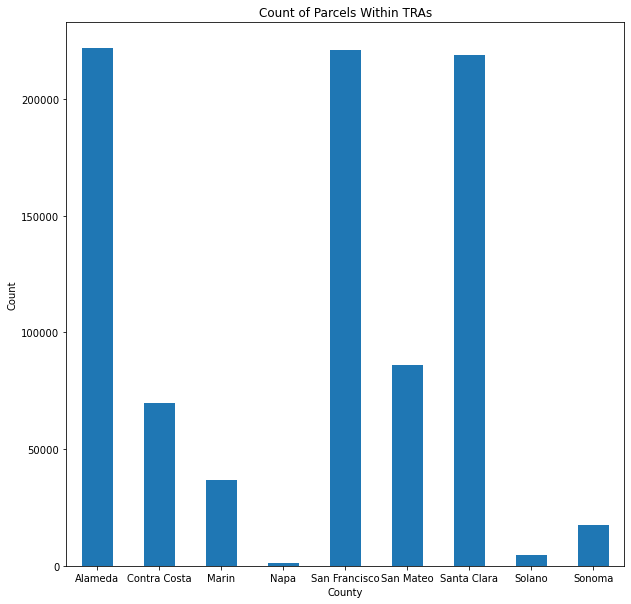

In [45]:
#Graph major stop parcels by county
parcels_tra_ct = tra_parcel_centroid[tra_parcel_centroid['tra'].notnull()].groupby(['fipco']).agg('size')

#plot
parcels_tra_ct.plot(kind='bar',figsize=(10,10))

#title and labels
plt.title('Count of Parcels Within TRAs')
plt.xlabel('County')
plt.ylabel('Count')

plt.xticks( 
    [0,1,2,3,4,5,6,7,8], # positions
    ['Alameda','Contra Costa','Marin','Napa','San Francisco','San Mateo','Santa Clara','Solano','Sonoma'], # labels
    rotation = 0 # default is 90
)

# convert to non-scientific notation 
plt.ticklabel_format(axis = 'y', style='plain');

In [47]:
#subset SF to view
parcels_tra_sf = tra_parcel_centroid[(tra_parcel_centroid['tra'] == 1) & 
                                               (tra_parcel_centroid['jurisdict'] == 'San Francisco')]

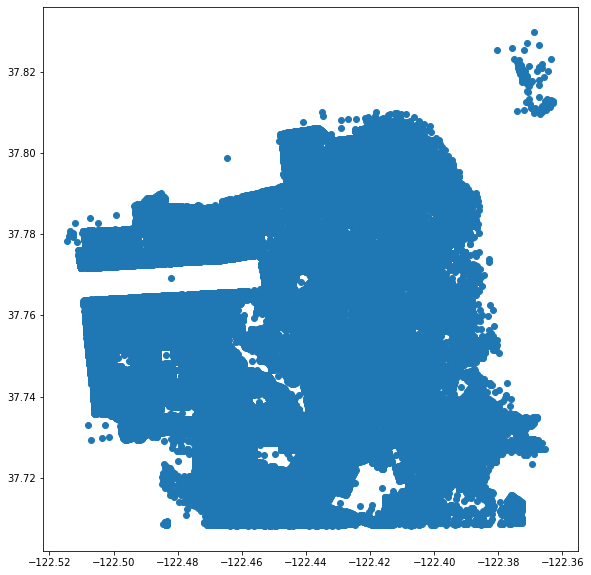

In [48]:
parcels_tra_sf.plot(figsize=(10,10));

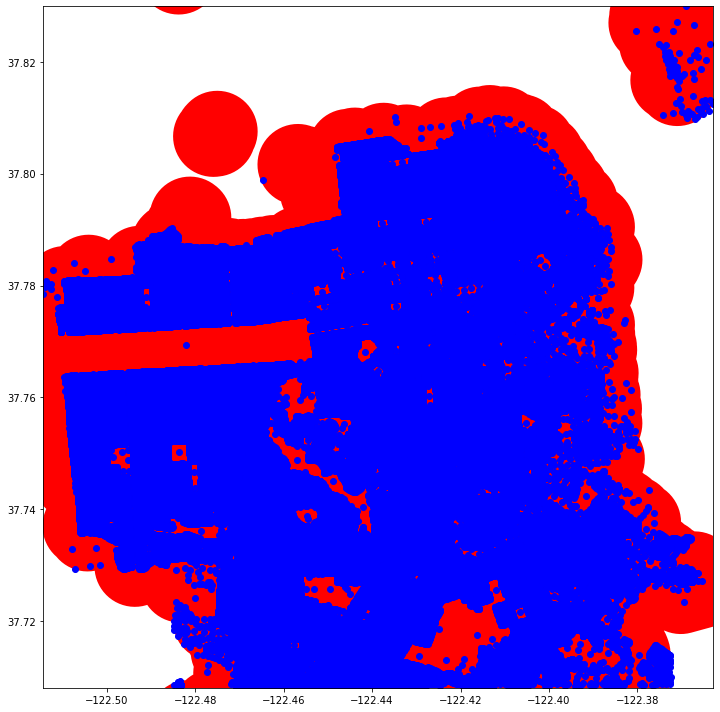

In [49]:
fig, ax = plt.subplots(figsize=(10,10))

tra.plot(color='red',ax=ax)

parcels_tra_sf.plot(color='blue',ax=ax)

# Crop map to sf bounds
minx, miny, maxx, maxy = parcels_major_st_sf.geometry.total_bounds

ax.set_xlim(minx,maxx)
ax.set_ylim(miny,maxy)

#Display map
plt.tight_layout()
plt.show()

In [50]:
#Fill tpa flag column NaN values
tra_parcel_centroid['tra'].fillna(0,inplace=True)

In [51]:
tra_parcel_centroid.head(10)

,joinid,geom_id,fipco,jurisdict,apn_frm,acres,tract_geoi,blkgp_geoi,x_centroid,y_centroid,geometry,index_right,tra,f_name,Shape_Length,Shape_Area
0,SN173872,SL1942158,CA097,Santa Rosa,173-170-001,1.35036110020719,06097152400,060971524004,-122.704221,38.480388,POINT (-122.70422 38.48039),NaN,0.0,NaN,NaN,NaN
1,AL044727,AL171604,CA001,Union City,483-42-103,5.27261949677121,06001440334,060014403341,-122.067495,37.595772,POINT (-122.06749 37.59577),0.0,1.0,Transit Rich Areas,12.296486,0.122582
2,CC121569,CC630071,CA013,Walnut Creek,None,0.700718319622156,06013340001,060133400013,-122.071217,37.926688,POINT (-122.07122 37.92669),NaN,0.0,NaN,NaN,NaN
3,AL066250,AL030349,CA001,Pleasanton,950-11-51,10.5813135682409,06001450701,060014507014,-121.811498,37.650312,POINT (-121.81150 37.65031),0.0,1.0,Transit Rich Areas,12.296486,0.122582
4,SN116826,SL2006047,CA097,Unincorporated Sonoma,110-090-027,93.5877827281533,06097154000,060971540002,-122.856075,38.568910,POINT (-122.85607 38.56891),NaN,0.0,NaN,NaN,NaN
5,CC179378,CC736109,CA013,San Pablo,None,0.0806802527044283,06013367200,060133672003,-122.330308,37.963123,POINT (-122.33031 37.96312),NaN,0.0,NaN,NaN,NaN
6,SF083225,SF910230,CA075,San Francisco,1939/093,101.278931944794,None,None,-122.374290,37.810525,POINT (-122.37429 37.81052),0.0,1.0,Transit Rich Areas,12.296486,0.122582
7,SF102855,SF1011883,CA075,San Francisco,2636/001,6.16755355259407,06075030102,060750301021,-122.460154,37.759735,POINT (-122.46015 37.75974),0.0,1.0,Transit Rich Areas,12.296486,0.122582
8,SM136952,SM1143264,CA081,Belmont,044-031-100,0.125234739436522,06081608800,060816088003,-122.301658,37.517426,POINT (-122.30166 37.51743),NaN,0.0,NaN,NaN,NaN
9,CC130986,CC764204,CA013,Richmond,None,0.231068040985594,06013378000,060133780001,-122.391856,37.928906,POINT (-122.39186 37.92891),0.0,1.0,Transit Rich Areas,12.296486,0.122582


In [54]:
#Upsert to socrata
upsert_df_socrata(tra_parcel_centroid[['joinid','tra']],housing_site_db_id,chunksize=100000)

upserting data to Socrata in 22 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
data upserted to 37cj-99yh
took 9.2613 minutes


## Step 6: Process environment datasets

#### California Protected Area Database
- California Protected Areas (CPAD) will be assigned to parcels using a simple point in polygon spatial join method. Parcel centroids that intersect CPAD areas will be flagged (0: Outside CPAD Area, 1: Inside CPAD Area) 

#### Fire Severity Risk: State and Local Responsibility Areas

Fire Severity Risk in State and Local Responsibility Areas for the San Francisco Bay Region. Data downloaded from the California Department of Forestry and Fire Protection.

This data set represents Moderate, High, and Very High Fire Hazard Severity Zones in State Responsibility Areas (SRA) and Very High Fire Hazard Severity Zones in Local Responsibility Areas (LRA) for the San Francisco Bay Region and surrounding counties. The data was assembled by the Metropolitan Transportation Commission from multiple shapefiles provided by the California Department of Forestry and Fire Protection (CAL FIRE). The SRA data was extracted from a statewide shapefile and the LRA data is a combination of county shapefiles.

- Columns from this dataset that will be associated with parcels include:
    - Fire Risk Severity 
    - Fire Responsibility Areas

- Fire risk severity will be assigned to parcels using a point in polygon spatial join method. 
- Fire severity classifications will be added to any parcel centroid that intersections the fire severity polygon. 

### Process California Protected Area Database data

In [7]:
cpad = pull_geodata_from_argis('84438219935a41d286a793f83a1a0b7d',client=gis)
cpad.head(5)

/Users/jcroff/anaconda3/envs/geo_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,SHAPE__Area,SHAPE__Length,access_typ,acres,agncy_web,label_name,layer,mng_ag_id,mng_ag_lev,mng_ag_typ,mng_agency,objectid,park_name,park_url,suid_nma,yr_est,geom
0,0.000467,0.414224,Open Access,1162.384,http://www.bakersfieldcity.us/recreation/,Kern River Parkway Park,City,1019,City,City Agency,"Bakersfield, City of",1,Kern River Parkway Park,http://www.bakersfieldcity.us/recreation/Kern_...,425,0,"MULTIPOLYGON (((-119.13376 35.35293, -119.1336..."
1,0.000113,0.119035,Open Access,287.621,http://www.anaheim.net/comm_svc/parks/,Deer Canyon Park,City,1006,City,City Agency,"Anaheim, City of",2,Deer Canyon Park,http://www.anaheim.net/comm_svc/parks/parkDeta...,129,0,"MULTIPOLYGON (((-117.76166 33.86609, -117.7613..."
2,0.000275,0.129395,Open Access,636.027,http://www.cityofarcata.org/rec,Arcata Community Forest,City,1432,City,City Agency,"Arcata, City of",3,Arcata Community Forest,http://www.cityofarcata.org/departments/enviro...,295,0,"MULTIPOLYGON (((-124.07493 40.87038, -124.0746..."
3,0.000536,0.129172,Open Access,1279.161,http://www.egret.org,Modini Mayacamas Preserves,Non Governmental Organization,3005,Non Profit,Non Profit - Conservation,Audubon Canyon Ranch,4,Modini Mayacamas Preserves,http://egret.org/visit_modini_mayacamas,383,0,"MULTIPOLYGON (((-122.76950 38.74085, -122.7657..."
4,0.000002,0.005766,Open Access,4.156,http://www.calexicorecreation.org/parks,Kennedy Gardens Large,City,1451,City,City Agency,"Calexico, City of",5,Kennedy Gardens Large,,33476,0,"MULTIPOLYGON (((-115.49104 32.68828, -115.4906..."


In [8]:
parcels_centroid.head(5)

,joinid,fipco,jurisdict,apn_frm,acres,tract_geoi,blkgp_geoi,reso_level,x_centroid,y_centroid,geometry
0,CC180451,CA013,Concord,None,0.179575078349944,06013335000,060133350001,Low Resource,-122.014012,37.968267,POINT (-122.01401 37.96827)
1,CC133378,CA013,Walnut Creek,None,0.244840660234907,06013338203,060133382032,Moderate Resource (Rapidly Changing),-122.049286,37.935739,POINT (-122.04929 37.93574)
2,CC180452,CA013,Concord,None,0.207501081340855,06013333200,060133332005,Moderate Resource,-121.994073,37.968477,POINT (-121.99407 37.96848)
3,CC141052,CA013,Concord,None,0.207006961527645,06013337300,060133373003,Moderate Resource,-122.017413,37.941901,POINT (-122.01741 37.94190)
4,SN168995,CA097,Windsor,161-350-016,0.961464869454214,06097153807,060971538072,Moderate Resource,-122.800496,38.564135,POINT (-122.80050 38.56414)


In [60]:
#Spatially join parcel centroids with CPAD
cpad_parcels_centroid = gp.sjoin(parcels_centroid,
                                 cpad,
                                how='left',
                                op='intersects')

/Users/jcroff/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs

  """


In [15]:
cpad_parcels_centroid.shape

(2142256, 28)

In [16]:
cpad_parcels_centroid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2142256 entries, 0 to 2142254
Data columns (total 28 columns):
 #   Column         Dtype   
---  ------         -----   
 0   joinid         object  
 1   fipco          object  
 2   jurisdict      object  
 3   apn_frm        object  
 4   acres_left     object  
 5   tract_geoi     object  
 6   blkgp_geoi     object  
 7   reso_level     object  
 8   x_centroid     float64 
 9   y_centroid     float64 
 10  geometry       geometry
 11  index_right    float64 
 12  SHAPE__Area    float64 
 13  SHAPE__Length  float64 
 14  access_typ     object  
 15  acres_right    float64 
 16  agncy_web      object  
 17  label_name     object  
 18  layer          object  
 19  mng_ag_id      float64 
 20  mng_ag_lev     object  
 21  mng_ag_typ     object  
 22  mng_agency     object  
 23  objectid       float64 
 24  park_name      object  
 25  park_url       object  
 26  suid_nma       float64 
 27  yr_est         float64 
dtypes: f

In [17]:
cpad_parcels_centroid.head(10)

,joinid,fipco,jurisdict,apn_frm,acres_left,tract_geoi,blkgp_geoi,reso_level,x_centroid,y_centroid,...,layer,mng_ag_id,mng_ag_lev,mng_ag_typ,mng_agency,objectid,park_name,park_url,suid_nma,yr_est
0,CC180451,CA013,Concord,None,0.179575078349944,06013335000,060133350001,Low Resource,-122.014012,37.968267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CC133378,CA013,Walnut Creek,None,0.244840660234907,06013338203,060133382032,Moderate Resource (Rapidly Changing),-122.049286,37.935739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CC180452,CA013,Concord,None,0.207501081340855,06013333200,060133332005,Moderate Resource,-121.994073,37.968477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CC141052,CA013,Concord,None,0.207006961527645,06013337300,060133373003,Moderate Resource,-122.017413,37.941901,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SN168995,CA097,Windsor,161-350-016,0.961464869454214,06097153807,060971538072,Moderate Resource,-122.800496,38.564135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,CC134749,CA013,Pleasant Hill,None,0.218644564190258,06013325000,060133250004,High Resource,-122.078701,37.936379,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,SN168996,CA097,Windsor,161-350-020,0.481664083622594,06097153807,060971538072,Moderate Resource,-122.800104,38.563617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,CC122626,CA013,Walnut Creek,None,0.203514295914162,06013340001,060133400012,Moderate Resource,-122.069124,37.927627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,CC122627,CA013,Walnut Creek,None,0.203939520962972,06013340001,060133400012,Moderate Resource,-122.069475,37.927625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,SN168997,CA097,Windsor,161-350-021,0.475716211170989,06097153807,060971538072,Moderate Resource,-122.800625,38.563596,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
cpad_parcels_centroid[cpad_parcels_centroid['index_right'].notnull()].shape

(12550, 29)

In [20]:
#Add cpad flag column
cpad_parcels_centroid['cpad'] = np.where(cpad_parcels_centroid['index_right'].notnull(),1,0)

In [30]:
#Review number of parcels flagged as park by county
cpad_parcels_centroid[cpad_parcels_centroid['cpad'] ==1].groupby(['cpad','fipco'])[['cpad','fipco']].sum()

cpad
cpad fipco      
1    CA001  2187
     CA013  1928
     CA041  1436
     CA055   580
     CA075   697
     CA081  1470
     CA085  2107
     CA095   948
     CA097  1197

In [31]:
cpad_parcels_centroid[['joinid','cpad']]

,joinid,cpad
0,CC180451,0
1,CC133378,0
2,CC180452,0
3,CC141052,0
4,SN168995,0
...,...,...
2142250,SC375948,0
2142251,SC375949,0
2142252,SC375950,0
2142253,SC375951,0


In [34]:
#Upsert to socrata
upsert_df_socrata(cpad_parcels_centroid[['joinid','cpad']],housing_site_db_id,chunksize=100000)

upserting data to Socrata in 22 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
data upserted to ce94-ebgq
took 9.3363 minutes


### Process Fire Severity Risk data

In [50]:
data_dir

'../../../../../Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data/'

In [47]:
ls '../../../../../Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data/'

Intermediate Data/
Potential_data_sources.xlsx
site_selection_prescreening_database.gdb/
tabular/


In [51]:
fiona.listlayers(os.path.join(data_dir,'site_selection_prescreening_database.gdb'))

['COCs_ACS2014_2018',
 'priority_development_areas_current',
 'US_Treasury_Opportunity_Zones_Bay_Area',
 'oehha_calenviroscreen3_bay_area',
 'u_richmond_mapping_inequality_redlining_07_2020',
 'hud_fair_market_rents_bay_area_7_28_20',
 'ca_healthy_places_index_bay_area_04_04_2018',
 'ctcac_hcd_resource_opportunity_areas_2020',
 'transit_rich_areas_2020',
 'cdf_fire_responsibility_areas_and_risk']

In [52]:
#Read fire severity risk data from project fgdb
fsr = gp.read_file(os.path.join(data_dir,'site_selection_prescreening_database.gdb'),
                  driver='FileGDB',
                  layer='cdf_fire_responsibility_areas_and_risk')

In [53]:
fsr.head(5)

,fipco,incorp,fra,haz_code,haz_class,Shape__Area,Shape__Length,Shape_Length,Shape_Area,geometry
0,CA001,,LRA,3,Very High,0.000106,0.086169,0.086169,0.000106,"MULTIPOLYGON (((-121.88522 37.59440, -121.8854..."
1,CA001,,LRA,3,Very High,0.000036,0.038931,0.038931,0.000036,"MULTIPOLYGON (((-121.90256 37.63428, -121.9024..."
2,CA001,,LRA,3,Very High,0.000362,0.255788,0.255788,0.000362,"MULTIPOLYGON (((-122.12722 37.71571, -122.1271..."
3,CA001,,LRA,3,Very High,0.000003,0.007693,0.007693,0.000003,"MULTIPOLYGON (((-122.12484 37.72801, -122.1249..."
4,CA001,Y,LRA,3,Very High,0.000067,0.050632,0.050632,0.000067,"MULTIPOLYGON (((-121.88361 37.62573, -121.8834..."


In [54]:
#Rename columns to match final data schema
fsr.rename(columns={'haz_class':'fire_risk','fra':'fire_autho'},inplace=True)

In [55]:
fsr.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5772 entries, 0 to 5771
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   fipco          5772 non-null   object  
 1   incorp         5772 non-null   object  
 2   fire_autho     5772 non-null   object  
 3   haz_code       5772 non-null   int64   
 4   fire_risk      5772 non-null   object  
 5   Shape__Area    5772 non-null   float64 
 6   Shape__Length  5772 non-null   float64 
 7   Shape_Length   5772 non-null   float64 
 8   Shape_Area     5772 non-null   float64 
 9   geometry       5772 non-null   geometry
dtypes: float64(4), geometry(1), int64(1), object(4)
memory usage: 451.1+ KB


In [58]:
fsr.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [61]:
#Spatial join parcel centroids to fire risk areas
fsr_parcels_centroid = gp.sjoin(parcels_centroid,
                               fsr,
                               how='inner',
                               op='intersects')

In [62]:
fsr_parcels_centroid.head(5)

,joinid,fipco_left,jurisdict,apn_frm,acres,tract_geoi,blkgp_geoi,reso_level,x_centroid,y_centroid,...,index_right,fipco_right,incorp,fire_autho,haz_code,fire_risk,Shape__Area,Shape__Length,Shape_Length,Shape_Area
38,CC120794,CA013,El Cerrito,None,0.114856121097938,06013385100,060133851001,High Resource,-122.305204,37.922757,...,33,CA013,Y,LRA,3,Very High,0.001911,0.335839,0.335839,0.001911
119,CC120815,CA013,El Cerrito,None,0.514528091144844,06013385100,060133851002,High Resource,-122.289392,37.922954,...,33,CA013,Y,LRA,3,Very High,0.001911,0.335839,0.335839,0.001911
138,CC133380,CA013,El Cerrito,None,0.0595049676238382,06013385100,060133851001,High Resource,-122.299664,37.932199,...,33,CA013,Y,LRA,3,Very High,0.001911,0.335839,0.335839,0.001911
147,CC122661,CA013,El Cerrito,None,0.123308172051936,06013385100,060133851001,High Resource,-122.304904,37.924318,...,33,CA013,Y,LRA,3,Very High,0.001911,0.335839,0.335839,0.001911
158,CC120823,CA013,El Cerrito,None,0.201309048572262,06013385100,060133851002,High Resource,-122.286839,37.923034,...,33,CA013,Y,LRA,3,Very High,0.001911,0.335839,0.335839,0.001911


In [64]:
fsr_parcels_centroid.shape

(179726, 21)

In [65]:
fsr_parcels_centroid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 179726 entries, 38 to 2112968
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   joinid         179726 non-null  object  
 1   fipco_left     179726 non-null  object  
 2   jurisdict      179726 non-null  object  
 3   apn_frm        129774 non-null  object  
 4   acres          179726 non-null  object  
 5   tract_geoi     179615 non-null  object  
 6   blkgp_geoi     179615 non-null  object  
 7   reso_level     178341 non-null  object  
 8   x_centroid     179726 non-null  float64 
 9   y_centroid     179726 non-null  float64 
 10  geometry       179726 non-null  geometry
 11  index_right    179726 non-null  int64   
 12  fipco_right    179726 non-null  object  
 13  incorp         179726 non-null  object  
 14  fire_autho     179726 non-null  object  
 15  haz_code       179726 non-null  int64   
 16  fire_risk      179726 non-null  object  
 17  

In [68]:
fsr_risk_by_county

fipco_left  fire_risk
CA001       High          4657
            Moderate      4504
            Very High    27762
CA013       High          7999
            Moderate      7546
            Very High    16020
CA041       High          4576
            Moderate      8639
            Very High     5864
CA055       High          1377
            Moderate      3825
            Very High     5054
CA081       High          2956
            Moderate      1310
            Very High    13625
CA085       High          5015
            Moderate      1466
            Very High    11906
CA095       High           573
            Moderate      2370
            Very High      175
CA097       High         12098
            Moderate     25666
            Very High     4743
dtype: int64

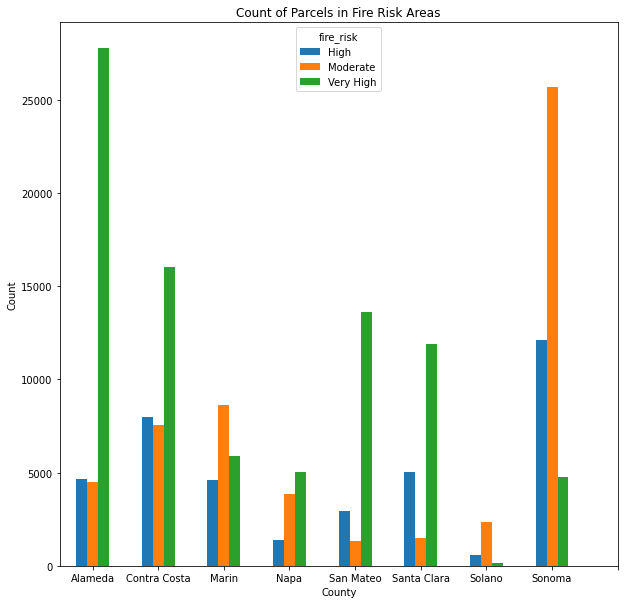

In [72]:
fsr_risk_by_county = fsr_parcels_centroid.groupby(['fipco_left','fire_risk'])[['fipco_left','fire_risk']].agg('size')

#plot
fsr_risk_by_county.unstack().plot(kind='bar',figsize=(10,10))

#title and labels
plt.title('Count of Parcels in Fire Risk Areas')
plt.xlabel('County')
plt.ylabel('Count')

plt.xticks( 
    [0,1,2,3,4,5,6,7,8], # positions
    ['Alameda','Contra Costa','Marin','Napa','San Mateo','Santa Clara','Solano','Sonoma'], # labels
    rotation = 0 # default is 90
)

# convert to non-scientific notation 
plt.ticklabel_format(axis = 'y', style='plain');

In [73]:
fsr_parcels_centroid[['joinid','fire_autho','fire_risk']]

,joinid,fire_autho,fire_risk
38,CC120794,LRA,Very High
119,CC120815,LRA,Very High
138,CC133380,LRA,Very High
147,CC122661,LRA,Very High
158,CC120823,LRA,Very High
...,...,...,...
2046472,SC279665,SRA,High
2061393,SC294619,SRA,Very High
2101159,SC334744,SRA,Very High
2074448,SC307695,SRA,Very High


In [74]:
upsert_df_socrata(fsr_parcels_centroid[['joinid','fire_autho','fire_risk']],housing_site_db_id)

upserting data to Socrata in 1 chunks of 179726 rows each
upserted chunk 0
data upserted to ce94-ebgq
took 1.205 minutes


## Step 7: Process planning datasets

#### Priority Development Areas

- Flag column (0: Outside PDA; 1: Inside PDA) 

#### Prior RHNA sites data

Following the adoption of the Regional Housing Need Assessment (RHNA), each jurisdiction is required to update its housing element to identify sites adequate to accommodate the number of units allocated to them. The parcel list was compiled from the housing opportunity sites inventories prepared by each of the Bay Area's 101 cities and nine counties as part of the 2007-2014 and 2015-2023 RHNA housing element cycles.

- RHNA 4 and RHNA 5 columns will be flagged (0: Not a previous RHNA site, 1: Was a previous RHNA site), depending on RHNA cycle. 

#### Zoning

Zoning data was compiled form zoning ordinances for every city and county in the Bay Area. This data includes the zoning code, description, overlay, and maxiumum allowable residential density as well as other information. 

- Columns from this dataset that will be associated with parcels include:
    - Zoning Code
    - Zoning Code Description
    - Zoning Overlay Description
    - Maximum Dwelling Units / Acre (Allowable Density) 

#### General Plan 

General plan data was compiled from some general plans but is incomplete. The data collected includes general plan code, description, and maxiumum allowable residential density. 

- Columns from this dataset that will be associated with parcels include: 
    - General Plan Code
    - General Plan Code Description
    - Maxium Dwelling Units / Acre (Allowable Density) 

#### Regional Property Characteristics 

Regional property chracteristics were collected from each of the 9-County Assessor's offices in the Bay Area. 

- Columns from this dataset that will be associated with parcels include: 
    - Existing Use Code
    - Existing Use Code Description 
    - Public Ownership 
    - Vacant Parcel 
    - Underutilized 

### Process Priority Development Area data

In [15]:
fiona.listlayers(os.path.join(data_dir,'site_selection_prescreening_database.gdb'))

['COCs_ACS2014_2018',
 'priority_development_areas_current',
 'US_Treasury_Opportunity_Zones_Bay_Area',
 'oehha_calenviroscreen3_bay_area',
 'u_richmond_mapping_inequality_redlining_07_2020',
 'hud_fair_market_rents_bay_area_7_28_20',
 'ca_healthy_places_index_bay_area_04_04_2018',
 'ctcac_hcd_resource_opportunity_areas_2020',
 'transit_rich_areas_2020',
 'cdf_fire_responsibility_areas_and_risk']

In [16]:
pda = gp.read_file(os.path.join(data_dir,'site_selection_prescreening_database.gdb'),
                  driver='FileGDB',
                  layer='priority_development_areas_current')

In [17]:
pda.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
pda.head(5)

,join_key,county,jurisdicti,pda_name,acres,Shape__Area,Shape__Length,Shape_Length,Shape_Area,geometry
0,230ec884-82c6-4074-a3e2-877bb1cea97b,Alameda,Berkeley,North Berkeley BART,13,0.000005,0.009432,0.009432,0.000005,"MULTIPOLYGON (((-122.28492 37.87463, -122.2847..."
1,0a13cdcd-d2e8-46e1-8652-60d54f28c843,Alameda,Fremont,Irvington Transit Priority Development Area,803,0.000331,0.095005,0.095005,0.000331,"MULTIPOLYGON (((-121.96350 37.53871, -121.9603..."
2,a75db8bd-4a27-4288-b878-24cee994e148,Alameda,Fremont,Centerville Transit Priority Development Area,582,0.000240,0.064045,0.064045,0.000240,"MULTIPOLYGON (((-122.00152 37.56471, -122.0015..."
3,84b5bd67-82eb-4202-9a66-a978d2218197,Alameda,Fremont,Downtown/City CenterTransit Priority Developme...,920,0.000380,0.089982,0.089982,0.000380,"MULTIPOLYGON (((-121.97847 37.54683, -121.9786..."
4,f50e7d2c-0fce-4fb6-83bb-7c037aa9446a,Alameda,Fremont,Warm Springs Innovation District Transit Prior...,913,0.000376,0.091934,0.091934,0.000376,"MULTIPOLYGON (((-121.94186 37.51030, -121.9417..."


In [24]:
#Spatially join parcel centroids w/ pdas
pda_parcel_centroid = gp.sjoin(parcels_centroid,
                              pda,
                              how='left',
                              op='intersects')

/Users/jcroff/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  """


In [25]:
pda_parcel_centroid.head(5)

,joinid,geom_id,fipco,jurisdict,apn_frm,acres_left,tract_geoi,blkgp_geoi,x_centroid,y_centroid,...,index_right,join_key,county,jurisdicti,pda_name,acres_right,Shape__Area,Shape__Length,Shape_Length,Shape_Area
0,SN173872,SL1942158,CA097,Santa Rosa,173-170-001,1.35036110020719,06097152400,060971524004,-122.704221,38.480388,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AL044727,AL171604,CA001,Union City,483-42-103,5.27261949677121,06001440334,060014403341,-122.067495,37.595772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CC121569,CC630071,CA013,Walnut Creek,None,0.700718319622156,06013340001,060133400013,-122.071217,37.926688,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AL066250,AL030349,CA001,Pleasanton,950-11-51,10.5813135682409,06001450701,060014507014,-121.811498,37.650312,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SN116826,SL2006047,CA097,Unincorporated Sonoma,110-090-027,93.5877827281533,06097154000,060971540002,-122.856075,38.568910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
pda_parcel_centroid[pda_parcel_centroid['index_right'].notnull()]

,joinid,geom_id,fipco,jurisdict,apn_frm,acres_left,tract_geoi,blkgp_geoi,x_centroid,y_centroid,...,index_right,join_key,county,jurisdicti,pda_name,acres_right,Shape__Area,Shape__Length,Shape_Length,Shape_Area
10,CC192300,CC714400,CA013,Unincorporated Contra Costa,None,0.0107064333196626,06013360200,060133602001,-122.301215,37.972901,...,24.0,7dc9dff2-68d2-453e-adc6-9560a480f040,Contra Costa,Unincorporated Contra Costa,Downtown El Sobrante Priority Development Area,230.0,0.000095,0.124724,0.124724,0.000095
11,CC192669,CC714342,CA013,Unincorporated Contra Costa,None,0.0156013635145529,06013360200,060133602001,-122.301126,37.973127,...,24.0,7dc9dff2-68d2-453e-adc6-9560a480f040,Contra Costa,Unincorporated Contra Costa,Downtown El Sobrante Priority Development Area,230.0,0.000095,0.124724,0.124724,0.000095
15,SC010415,SC1268027,CA085,Gilroy,None,0.0237236049164839,06085512506,060855125062,-121.575590,37.018001,...,34.0,ea3bffaf-3122-4d86-9883-d8d18400d97c,Santa Clara,Gilroy,Downtown Gilroy,479.0,0.000196,0.109846,0.109846,0.000196
19,SC228733,SC1375125,CA085,Unincorporated Santa Clara,None,0.200898056190609,06085503903,060855039032,-121.835237,37.363807,...,180.0,dc1e980d-6495-42e0-83d0-e5f876e3be43,Santa Clara,San Jose,Santa Clara Valley Transportation Authority Ci...,3642.0,0.001498,1.123538,1.123538,0.001498
27,SC213904,SC1265502,CA085,Gilroy,None,0.170411798048876,06085512508,060855125082,-121.567718,37.000698,...,34.0,ea3bffaf-3122-4d86-9883-d8d18400d97c,Santa Clara,Gilroy,Downtown Gilroy,479.0,0.000196,0.109846,0.109846,0.000196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142240,MA013826,MA790365,CA041,San Rafael,013-042-08,3.08113060833781,06041112100,060411121001,-122.520905,37.966105,...,166.0,3d519d55-feb2-4b90-a948-fee127d9a740,Marin,San Rafael,Downtown,503.0,0.000209,0.051738,0.051738,0.000209
2142241,SF018272,SF926117,CA075,San Francisco,0312/031,0.242002898625191,06075011700,060750117002,-122.403870,37.787690,...,200.0,d944183f-d5d3-44e4-97db-6cd42a37a9ba,San Francisco,San Francisco,Downtown/Van Ness/Northeast Neighborhoods,1933.0,0.000800,0.140580,0.140580,0.000800
2142244,AL389464,AL086827,CA001,Fremont,525-621-42-4,1.49271062481314,06001442301,060014423013,-121.958009,37.530926,...,1.0,0a13cdcd-d2e8-46e1-8652-60d54f28c843,Alameda,Fremont,Irvington Transit Priority Development Area,803.0,0.000331,0.095005,0.095005,0.000331
2142246,AL367689,AL086395,CA001,Fremont,525-621-22-2,1.20702945175543,06001442301,060014423013,-121.956906,37.530590,...,1.0,0a13cdcd-d2e8-46e1-8652-60d54f28c843,Alameda,Fremont,Irvington Transit Priority Development Area,803.0,0.000331,0.095005,0.095005,0.000331


In [28]:
pda_parcel_centroid['pda'] = np.where(pda_parcel_centroid['index_right'].notnull(),1,0)

In [31]:
pda_parcel_centroid[pda_parcel_centroid['pda'] == 1].head(5)

,joinid,geom_id,fipco,jurisdict,apn_frm,acres_left,tract_geoi,blkgp_geoi,x_centroid,y_centroid,...,join_key,county,jurisdicti,pda_name,acres_right,Shape__Area,Shape__Length,Shape_Length,Shape_Area,pda
10,CC192300,CC714400,CA013,Unincorporated Contra Costa,None,0.0107064333196626,06013360200,060133602001,-122.301215,37.972901,...,7dc9dff2-68d2-453e-adc6-9560a480f040,Contra Costa,Unincorporated Contra Costa,Downtown El Sobrante Priority Development Area,230.0,0.000095,0.124724,0.124724,0.000095,1
11,CC192669,CC714342,CA013,Unincorporated Contra Costa,None,0.0156013635145529,06013360200,060133602001,-122.301126,37.973127,...,7dc9dff2-68d2-453e-adc6-9560a480f040,Contra Costa,Unincorporated Contra Costa,Downtown El Sobrante Priority Development Area,230.0,0.000095,0.124724,0.124724,0.000095,1
15,SC010415,SC1268027,CA085,Gilroy,None,0.0237236049164839,06085512506,060855125062,-121.575590,37.018001,...,ea3bffaf-3122-4d86-9883-d8d18400d97c,Santa Clara,Gilroy,Downtown Gilroy,479.0,0.000196,0.109846,0.109846,0.000196,1
19,SC228733,SC1375125,CA085,Unincorporated Santa Clara,None,0.200898056190609,06085503903,060855039032,-121.835237,37.363807,...,dc1e980d-6495-42e0-83d0-e5f876e3be43,Santa Clara,San Jose,Santa Clara Valley Transportation Authority Ci...,3642.0,0.001498,1.123538,1.123538,0.001498,1
27,SC213904,SC1265502,CA085,Gilroy,None,0.170411798048876,06085512508,060855125082,-121.567718,37.000698,...,ea3bffaf-3122-4d86-9883-d8d18400d97c,Santa Clara,Gilroy,Downtown Gilroy,479.0,0.000196,0.109846,0.109846,0.000196,1


In [33]:
#Upsert to socrata
upsert_df_socrata(pda_parcel_centroid[['joinid','pda']],housing_site_db_id,chunksize=100000)

upserting data to Socrata in 22 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
data upserted to 37cj-99yh
took 9.3732 minutes


In [12]:
pda = pull_geodata_from_argis('85043289ac774a928e4628aa904a317c',client=gis)

CRSError: Invalid CRS input: {'EPSG:4326'}

### Process prior RHNA Sites data

In [78]:
rhna_sites = pull_geodata_from_argis('da0765ab82ae475d985688e140f931bd',client=agol_gis)

/Users/jcroff/anaconda3/envs/geo_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [79]:
rhna_sites.head(5)

,Shape__Area,Shape__Length,aff_am,aff_l,aff_m,aff_vl,allowden,allowhigh,allowlow,apn,...,num_vl,objectid,pdaparcel,relcapcty,rhnacyc,rhnayrs,siteconst,sitetype,zoning,geom
0,9.683936e-08,0.001269,None,None,None,None,79,79,0,055-1825-020-00,...,0,42134,Y,None,RHNA4,2007-2014,None,Underutilized,C-SA,"MULTIPOLYGON (((-122.26618 37.86184, -122.2664..."
1,4.085769e-08,0.001028,None,None,None,None,97,97,0,057-2059-012-00,...,0,42135,Y,None,RHNA4,2007-2014,None,Underutilized,C-1,"MULTIPOLYGON (((-122.27251 37.87207, -122.2726..."
2,6.365599e-08,0.001089,None,None,None,None,1,1,0,055-1829-011-00,...,0,42136,None,None,RHNA4,2007-2014,None,Vacant,R-2A,"MULTIPOLYGON (((-122.26420 37.86264, -122.2643..."
3,1.648737e-07,0.001633,None,None,None,None,97,97,0,057-2046-001-00,...,0,42137,Y,None,RHNA4,2007-2014,None,Underutilized,C-1,"MULTIPOLYGON (((-122.26784 37.87269, -122.2680..."
4,1.102803e-07,0.001333,None,None,None,None,97,97,0,057-2053-008-01,...,0,42138,Y,None,RHNA4,2007-2014,None,Underutilized,C-1,"MULTIPOLYGON (((-122.26964 37.87213, -122.2700..."


In [80]:
rhna_sites.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 42133 entries, 0 to 42132
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Shape__Area    42133 non-null  float64 
 1   Shape__Length  42133 non-null  float64 
 2   aff_am         3084 non-null   object  
 3   aff_l          1591 non-null   object  
 4   aff_m          1800 non-null   object  
 5   aff_vl         1163 non-null   object  
 6   allowden       23912 non-null  object  
 7   allowhigh      42133 non-null  int64   
 8   allowlow       42133 non-null  int64   
 9   apn            42105 non-null  object  
 10  bundled        5924 non-null   object  
 11  county         42133 non-null  object  
 12  currunits      42133 non-null  int64   
 13  desafford      6044 non-null   object  
 14  existuse       36590 non-null  object  
 15  gacres         42133 non-null  float64 
 16  genplan        37177 non-null  object  
 17  infcapcty      14722 no

In [89]:
rhna_sites.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [96]:
#Spatially join parcel centroids with rhna dataset
rhna_parcels_centroid = gp.sjoin(parcels_centroid,
                                rhna_sites,
                                how='left',
                                op='intersects')

/Users/jcroff/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs

  """


In [97]:
rhna_parcels_centroid.head(5)

,joinid,fipco,jurisdict_left,apn_frm,acres,tract_geoi,blkgp_geoi,reso_level,x_centroid,y_centroid,...,num_m,num_vl,objectid,pdaparcel,relcapcty,rhnacyc,rhnayrs,siteconst,sitetype,zoning
0,CC180451,CA013,Concord,None,0.179575078349944,06013335000,060133350001,Low Resource,-122.014012,37.968267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CC133378,CA013,Walnut Creek,None,0.244840660234907,06013338203,060133382032,Moderate Resource (Rapidly Changing),-122.049286,37.935739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CC180452,CA013,Concord,None,0.207501081340855,06013333200,060133332005,Moderate Resource,-121.994073,37.968477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CC141052,CA013,Concord,None,0.207006961527645,06013337300,060133373003,Moderate Resource,-122.017413,37.941901,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SN168995,CA097,Windsor,161-350-016,0.961464869454214,06097153807,060971538072,Moderate Resource,-122.800496,38.564135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
rhna_parcels_centroid.groupby(['rhnacyc']).agg('size')

rhnacyc
RHNA4    49909
RHNA5    42840
dtype: int64

In [100]:
rhna_parcels_centroid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2179514 entries, 0 to 2142254
Data columns (total 46 columns):
 #   Column           Dtype   
---  ------           -----   
 0   joinid           object  
 1   fipco            object  
 2   jurisdict_left   object  
 3   apn_frm          object  
 4   acres            object  
 5   tract_geoi       object  
 6   blkgp_geoi       object  
 7   reso_level       object  
 8   x_centroid       float64 
 9   y_centroid       float64 
 10  geometry         geometry
 11  index_right      float64 
 12  Shape__Area      float64 
 13  Shape__Length    float64 
 14  aff_am           object  
 15  aff_l            object  
 16  aff_m            object  
 17  aff_vl           object  
 18  allowden         object  
 19  allowhigh        float64 
 20  allowlow         float64 
 21  apn              object  
 22  bundled          object  
 23  county           object  
 24  currunits        float64 
 25  desafford        object  
 26  existu

In [101]:
parcels_centroid.shape

(2142255, 11)

In [105]:
#create new flag columns
rhna_parcels_centroid['rhna_4'] = np.where((rhna_parcels_centroid['rhnacyc'] == 'RHNA4'), 1,0)

In [106]:
rhna_parcels_centroid['rhna_5'] = np.where((rhna_parcels_centroid['rhnacyc'] == 'RHNA5'), 1,0)

In [112]:
rhna_parcels_centroid[['joinid','rhnacyc','rhna_4','rhna_5']][rhna_parcels_centroid['rhnacyc'].isnull()]

,joinid,rhnacyc,rhna_4,rhna_5
0,CC180451,NaN,0,0
1,CC133378,NaN,0,0
2,CC180452,NaN,0,0
3,CC141052,NaN,0,0
4,SN168995,NaN,0,0
...,...,...,...,...
2142250,SC375948,NaN,0,0
2142251,SC375949,NaN,0,0
2142252,SC375950,NaN,0,0
2142253,SC375951,NaN,0,0


In [125]:
parcels_centroid.shape

(2142255, 11)

In [126]:
rhna_parcels_centroid.shape

(2179514, 48)

In [122]:
rhna_parcels_centroid[rhna_parcels_centroid.duplicated(subset=['joinid'])].shape

(37259, 48)

In [123]:
#De-duplicate
rhna_parcels_centroid_dedup = rhna_parcels_centroid.drop_duplicates(subset=['joinid'])

In [124]:
rhna_parcels_centroid_dedup.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2142255 entries, 0 to 2142254
Data columns (total 48 columns):
 #   Column           Dtype   
---  ------           -----   
 0   joinid           object  
 1   fipco            object  
 2   jurisdict_left   object  
 3   apn_frm          object  
 4   acres            object  
 5   tract_geoi       object  
 6   blkgp_geoi       object  
 7   reso_level       object  
 8   x_centroid       float64 
 9   y_centroid       float64 
 10  geometry         geometry
 11  index_right      float64 
 12  Shape__Area      float64 
 13  Shape__Length    float64 
 14  aff_am           object  
 15  aff_l            object  
 16  aff_m            object  
 17  aff_vl           object  
 18  allowden         object  
 19  allowhigh        float64 
 20  allowlow         float64 
 21  apn              object  
 22  bundled          object  
 23  county           object  
 24  currunits        float64 
 25  desafford        object  
 26  existu

In [115]:
rhna_parcels_centroid_dedup.head(5)

,joinid,fipco,jurisdict_left,apn_frm,acres,tract_geoi,blkgp_geoi,reso_level,x_centroid,y_centroid,...,objectid,pdaparcel,relcapcty,rhnacyc,rhnayrs,siteconst,sitetype,zoning,rhna_4,rhna_5
2484,SN183301,CA097,Santa Rosa,182-520-050,2.51594600478729,06097152202,060971522022,Moderate Resource,-122.671003,38.464854,...,62723.0,None,6,RHNA4,2007-2014,None,None,R-1-6,1,0
3715,SN134166,CA097,Santa Rosa,134-410-008,0.130613123665026,06097153200,060971532004,Low Resource,-122.732436,38.406292,...,61990.0,Y,30,RHNA4,2007-2014,Likely California Tiger Salamander habitat,None,PI,1,0
3715,SN134166,CA097,Santa Rosa,134-410-008,0.130613123665026,06097153200,060971532004,Low Resource,-122.732436,38.406292,...,62049.0,Y,80,RHNA4,2007-2014,Likely California Tiger Salamander habitat,None,PI,1,0
4850,CC189202,CA013,Concord,None,0.120194159318271,06013335000,060133350003,Low Resource,-122.024952,37.974140,...,84192.0,Y,None,RHNA5,2015-2023,None,None,None,0,1
6520,SM214886,CA081,San Bruno,017-080-150,82.0683724615891,06081614000,060816140003,High Resource,-122.463918,37.630298,...,80849.0,None,36,RHNA5,2015-2023,N,"Underutilized, margi",OS,0,1


In [129]:
#Upsert to socrata
upsert_df_socrata(rhna_parcels_centroid_dedup[['joinid','rhna_4','rhna_5']],housing_site_db_id,chunksize=100000)

upserting data to Socrata in 22 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
data upserted to ce94-ebgq
took 12.6688 minutes


### Process zoning and general plan datasets

In [56]:
# Read in zoning and general plan bridge table
gp_zoning_bridge = pull_df_from_socrata('c2b7-6c8p')

pulling data in 9 chunks of 250000 rows each
pulling chunk 0
pulling chunk 1
pulling chunk 2
pulling chunk 3
pulling chunk 4
pulling chunk 5
pulling chunk 6
pulling chunk 7
pulling chunk 8
took 23.2182 seconds


In [83]:
gp_zoning_bridge.head(20)

,geom_id,recid,editor,edit_date
0,N7048726851848113656,6c459d2c-daf3-4cac-b20c-8472c10dd792,NaN,NaN
1,N2250681206250696451,025e717f-900c-4011-8503-7b102c7a0933,NaN,NaN
2,N7483598866155113920,437e90f2-8cac-4057-b658-678848f7c019,NaN,03-09-2020
3,N8908818910097817915,dc323e46-2ca5-4c65-aaea-bd13d8420b3d,NaN,NaN
4,N1486116264581352684,5a6d3363-b377-4431-8ac8-35aa1593225d,NaN,12-19-2019
5,1706503900753737212,503b7b62-2d48-42e6-8e95-7d2dbcfc02a5,NaN,03-09-2020
6,1097968920311271492,b554e520-233b-43fe-941d-6cf00c8280cc,NaN,03-09-2020
7,N1048500707510671610,5ad2113b-8731-4f8e-a8d3-524bf26349ea,NaN,03-09-2020
8,7069954163290417020,a3400a6b-7d2b-490e-a6f4-9fdf44f3c2e9,NaN,NaN
9,4277252015918488864,4b04ea96-f0a5-4137-8fd4-35e6f41ee663,NaN,NaN


In [58]:
gp_zoning_bridge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2044386 entries, 0 to 2044385
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   geom_id    object
 1   recid      object
 2   editor     object
 3   edit_date  object
dtypes: object(4)
memory usage: 62.4+ MB


In [71]:
# Pull in zoning data from socrata 
zoning = pull_df_from_socrata('r3pf-wkks')
zoning.head(5)

pulling data in 1 chunks of 5197 rows each
pulling chunk 0
took 3.5885 seconds


,recid,county_name,city_name,zn_code,zn_description,zn_area_overlay,regional_lu_class,max_far,max_dua,building_height,minimum_lot_sqft,lot_coverage,units_per_lot,editor,edit_date,zn_code_color,source
0,0182e52b-75aa-4e05-9196-6b4deb7d9bdd,Alameda,Alameda,R-1,One-Family Residence District,NaN,2.0,1.2,8.712,30.0,5000.0,0.4,1.0,Kearey Smith,2019-08-28T00:00:00,#FFFFFF,NaN
1,a42579cd-ae0c-477c-b981-5455d20698cd,Alameda,Alameda,R-1-A-H-30,One-Family Residence District,NaN,2.0,1.2,8.712,30.0,5000.0,0.4,1.0,Kearey Smith,2019-04-29T00:00:00,#FFFFFF,NaN
2,e20a4df9-7417-4764-bd26-99e19916ebba,Alameda,Alameda,R-1-A-H-40,One-Family Residence District,NaN,2.0,1.2,8.712,30.0,5000.0,0.4,1.0,Kearey Smith,2019-04-29T00:00:00,#FFFFFF,NaN
3,c0a4fb19-8f44-49de-91e4-c983c4fe2df8,Alameda,Alameda,R-1-A-PD,One-Family Residence District,Planned Development District,2.0,1.2,8.712,30.0,5000.0,0.4,1.0,Kearey Smith,2019-04-29T00:00:00,#FFFFFF,NaN
4,7cb57357-2110-4ff8-ac79-ee04ec3c4612,Alameda,Alameda,R-1-A-PD,One-Family Residence District,Planned Development District,2.0,1.2,8.712,30.0,5000.0,0.4,1.0,Kearey Smith,2019-04-29T00:00:00,#FFFE55,NaN


In [72]:
zoning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5197 entries, 0 to 5196
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recid              5197 non-null   object 
 1   county_name        5160 non-null   object 
 2   city_name          5197 non-null   object 
 3   zn_code            5196 non-null   object 
 4   zn_description     5052 non-null   object 
 5   zn_area_overlay    1098 non-null   object 
 6   regional_lu_class  5188 non-null   float64
 7   max_far            4944 non-null   float64
 8   max_dua            4456 non-null   float64
 9   building_height    3077 non-null   float64
 10  minimum_lot_sqft   1373 non-null   float64
 11  lot_coverage       112 non-null    float64
 12  units_per_lot      812 non-null    float64
 13  editor             5197 non-null   object 
 14  edit_date          5197 non-null   object 
 15  zn_code_color      5197 non-null   object 
 16  source             595 n

In [73]:
# Merge gp and zoning bridge table w/ zoning table
zoning_and_bridge = pd.merge(gp_zoning_bridge[['geom_id','recid']],
                            zoning[['recid','zn_code','zn_description','zn_area_overlay','max_dua']],
                            on='recid',
                            how='inner')

In [74]:
zoning_and_bridge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2022311 entries, 0 to 2022310
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   geom_id          object 
 1   recid            object 
 2   zn_code          object 
 3   zn_description   object 
 4   zn_area_overlay  object 
 5   max_dua          float64
dtypes: float64(1), object(5)
memory usage: 108.0+ MB


In [75]:
#Rename max_far column to match site selection schema
zoning_and_bridge.rename(columns={'max_dua':'zn_max_dua'},inplace=True)

In [76]:
zoning_and_bridge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2022311 entries, 0 to 2022310
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   geom_id          object 
 1   recid            object 
 2   zn_code          object 
 3   zn_description   object 
 4   zn_area_overlay  object 
 5   zn_max_dua       float64
dtypes: float64(1), object(5)
memory usage: 108.0+ MB


In [82]:
zoning_and_bridge.head(10)

,geom_id,recid,zn_code,zn_description,zn_area_overlay,zn_max_dua
0,N7048726851848113656,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
1,4974405566792209754,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
2,1287593219279599460,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
3,7767969963689623036,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
4,N5605796467262203641,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
5,3162063837881530328,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
6,3437294762313958568,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
7,N3149764479670251269,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
8,N956514525116259204,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN
9,N1053274242604597070,6c459d2c-daf3-4cac-b20c-8472c10dd792,PD,Planned Development,NaN,NaN


In [77]:
#join to parcels 
zoning_and_bridge_parcels = pd.merge(parcels[['joinid','geom_id']],
                                    zoning_and_bridge,
                                    on='geom_id',
                                    how='left')

In [78]:
zoning_and_bridge_parcels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2142255 entries, 0 to 2142254
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   joinid           object 
 1   geom_id          object 
 2   recid            object 
 3   zn_code          object 
 4   zn_description   object 
 5   zn_area_overlay  object 
 6   zn_max_dua       float64
dtypes: float64(1), object(6)
memory usage: 130.8+ MB


In [81]:
zoning_and_bridge_parcels[zoning_and_bridge_parcels['recid'].notnull()]

,joinid,geom_id,recid,zn_code,zn_description,zn_area_overlay,zn_max_dua
1878150,AL093294,AL401359,fcbcc710-4ce6-11e9-b9cf-938c676b321a,U,Unclassified,NaN,0.0


In [23]:
#Upsert zoning data to socrata
upsert_df_socrata(zoning_and_bridge[['joinid','zn_code','zn_description','zn_area_overlay','zn_max_dua']],
                  housing_site_db_id,
                  chunksize=100000)

upserting data to Socrata in 21 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
data upserted to ce94-ebgq
took 10.4883 minutes
